# Neural network classification with PyTorch


## 1. Make classification data and get it ready

In [67]:
import sklearn
import torch
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt

In [68]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
len(X), len(y)

(1000, 1000)

In [69]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [70]:
# Make DataFrame of circle data
circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2" : X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


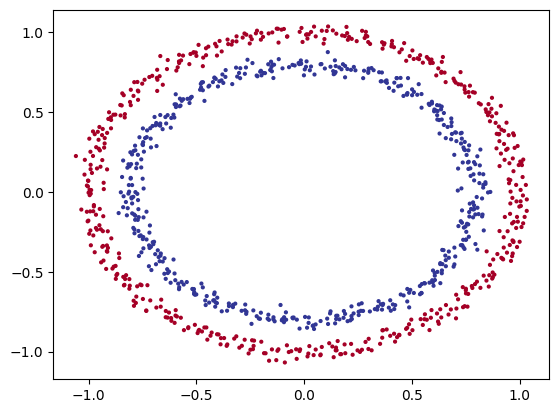

In [71]:
# Visualize
plt.scatter(X[:, 0],
            X[:, 1],
            s=4,
            c=y,
            cmap=plt.cm.RdYlBu);


### 1.1 Check input and output shapes

In [72]:
X.shape, y.shape

((1000, 2), (1000,))

In [73]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [74]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.shape, X.dtype

(torch.Size([1000, 2]), torch.float32)

In [75]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [76]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [77]:
# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1.3 Create a function for accuracy calculation

In [78]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 2. Train model

Training Loop:
1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Back propagation
5. Optimizer step (gradient descent)

In [79]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2, 10)
    self.layer_2 = nn.Linear(10, 10)
    self.layer_3 = nn.Linear(10, 1)
    self.relu = nn.ReLU()
  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = CircleModel().to(device)
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [80]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.1)

In [81]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 2000

for epoch in range(epochs):
  model.train()
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} Loss: {loss:.4f} Test Loss:{test_loss:.4f} Acc: {acc:.2f} Test Acc: {test_acc:.2f}")




Epoch: 0 Loss: 0.6929 Test Loss:0.6932 Acc: 50.00 Test Acc: 50.00
Epoch: 100 Loss: 0.6912 Test Loss:0.6910 Acc: 52.88 Test Acc: 52.50
Epoch: 200 Loss: 0.6898 Test Loss:0.6894 Acc: 53.37 Test Acc: 55.00
Epoch: 300 Loss: 0.6879 Test Loss:0.6872 Acc: 53.00 Test Acc: 56.00
Epoch: 400 Loss: 0.6852 Test Loss:0.6841 Acc: 52.75 Test Acc: 56.50
Epoch: 500 Loss: 0.6810 Test Loss:0.6794 Acc: 52.75 Test Acc: 56.50
Epoch: 600 Loss: 0.6751 Test Loss:0.6729 Acc: 54.50 Test Acc: 56.00
Epoch: 700 Loss: 0.6666 Test Loss:0.6632 Acc: 58.38 Test Acc: 59.00
Epoch: 800 Loss: 0.6516 Test Loss:0.6476 Acc: 64.00 Test Acc: 67.50
Epoch: 900 Loss: 0.6236 Test Loss:0.6215 Acc: 74.00 Test Acc: 79.00
Epoch: 1000 Loss: 0.5682 Test Loss:0.5738 Acc: 87.75 Test Acc: 86.50
Epoch: 1100 Loss: 0.4815 Test Loss:0.4993 Acc: 93.50 Test Acc: 90.50
Epoch: 1200 Loss: 0.3706 Test Loss:0.4059 Acc: 97.75 Test Acc: 92.00
Epoch: 1300 Loss: 0.2546 Test Loss:0.3033 Acc: 99.00 Test Acc: 96.50
Epoch: 1400 Loss: 0.1718 Test Loss:0.2211 Acc: